# Stéréovision

![Suzanne](main.png)

La stéréovision est une discipline qui s’occupe de reconstruire des informations 3D à partir d’images. Ppour que la reconstruction d’un point soit possible, il faut plusieurs images de ce point. Ces images doivent être prises de points de vue différents. L’étape clé de la reconstruction, qui pose souvent problème, est d’indentifier l’image du point à reconstruire dans chacune des vues.

## Géométrie épipolaire

La géométrie épipolaire fait intervenir deux caméras. La géométrie épipolaire décrit les propriétés géométriques entre deux vues d’une même scène et ne dépend que des paramètres intrinsèques des caméras et de leurs positions relatives. Elle fournit, en particulier, la contrainte épipolaire, qui nous sera très utile pour produire les appariements entre vues.

## La matrice fondamentale

![Géométrie épipolaire - Sanyam Kapoor](epipolar.png)

Imaginons que nous ayons deux images, droite et gauche, de l’espace monde. Prenons un point $\vec{x}$ dans l’espace image droit. Le point $\vec{X}$ de l’espace monde, dont $\vec{x}$ est l’image, peut se trouver n’importe où sur la droite passant par $\vec{x}$ et le centre optique de la caméra de droite. Nous appellerons cette droite, le rayon retro-projeté de $\vec{x}$. Notons $\vec{x}'$ l’image de $\vec{X}$ dans l’espace image gauche. Le lieu de $\vec{x}'$ est donc la droite image du rayon retro-projeté de $\vec{x}$. Cette droite est appelée ligne épipolaire et notée $\vec{l}'$. La ligne épipolaire passe par l’épipole $\vec{e}'$, image du centre optique de la caméra de droite.

En géométrie projective 2D, une droite d’équation $ax+by+c = 0$ est représentée par un vecteur à trois composantes $(a, b, c)^T$ définies à un facteur près. On a donc la relation suivante:

>Le point $\vec{x}$ appartient à la droite $\vec{l}$ si et seulement si $x^T\vec{l} = 0$.

De plus, en géométrie projective 2D, les relations remarquables suivantes sont valables:

- L’intersection de deux lignes $l$ et $l'$ est donnée par $x = l \times l'$,
- La droite passant par deux points $x$ et $x'$ est donnée par $l = x \times x'$.

Notons que le produit vectoriel peut être écrit comme un produit de matrice $x \times y = [x]_\times y$ où

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

Pour trouver l’équation de la ligne épipolaire dans l’espace image gauche, il nous suffit donc de trouver les coordonnées de deux points de cette ligne. Le premier est l’image $P'\vec{C}$ du centre optique $\vec{C}$ de la caméra de droite où $P'$ est la matrice de projection de la caméra de gauche. Le deuxième est $P'P^{+}\vec{x}$ où $P^{+}$ est la pseudo inverse de la matrice de projection $P$ de la caméra de droite. La ligne épipolaire a donc pour équation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ avec $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ est appelée matrice fondamentale.

Comme la ligne épipolaire $\vec{l}' = F\vec{x}$ est le lieu de $\vec{x}'$, $\vec{x}'$ appartient donc à $\vec{l}'$ ce qui conduit à la contrainte épipolaire :

>**La matrice fondamentale est telle que pour toute paire de points se correspondant $\vec{x} \leftrightarrow \vec{x}'$ dans les deux images, on a $\vec{x}'^{T}F\vec{x} = 0$.**

## Calcul de la matrice fondamentale

La matrice fondamentale $F$ a sept degrés de liberté. Elle possède neuf composantes mais celles-ci sont définies à un facteur d’échelle près, ce qui enlève un degré de liberté. De plus, la matrice $F$ est une matrice singulière ($det(F) = 0$) ce qui nous fait bien sept degrés de liberté. Il nous faut donc sept correspondances minimum pour calculer $F$. L’équation $x'^{T}_iFx_i = 0$ et les sept correspondances nous permettent d’écrire un système d’équations de la forme $Af = 0$, où $f$ est le vecteur qui contient les composantes de la matrice $F$. Admettons que $A$ soit une matrice 7×9 de rang 7. La solution générale de $Af = 0$ peut s’écrire $\alpha f_1 + (1−\alpha) f_2$ où $f_1$ et $f_2$ sont deux solutions particulières indépendantes de $Af = 0$. On utilise ensuite la contrainte de singularité $det(\alpha F_1 + (1 − \alpha)F_2) = 0$ pour déterminer $\alpha$. La contrainte de singularité donnant lieu à une équation du troisième degré, on pourra avoir une ou trois solutions pour $F$.

## OpenCV

En pratique vous allez utiliser la bibliothèque OpenCV. En python, vous avez accès à ses fonctions grâce au module `cv2`.

Vous pouvez trouver de l'aide concernant les fonctions de calibration et de reconstruction à la page https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Objectif

Dans le zip de l'énoncé vous trouverez deux séquences d'images prise par deux caméras pendant le balayage d'un objet par un plan laser.

![Laser](scanRight/scan0010.png)

Vous trouverez également des prises de vue d'un damier dans différentes position qui vous aideront à calibrer vos caméras.

![Damier](chessboards/c2Right.png)

Le but est de reconstruire en 3D l'objet scanné.

chessboards\c1Left.png


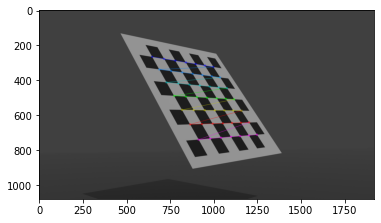

chessboards\c1Right.png


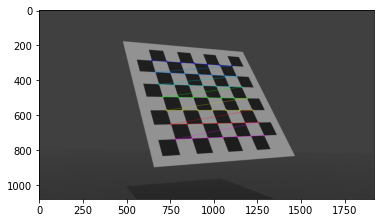

chessboards\c2Left.png


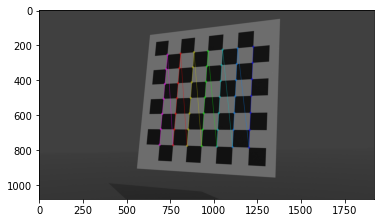

chessboards\c2Right.png


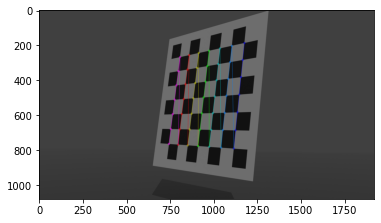

chessboards\c4Left.png


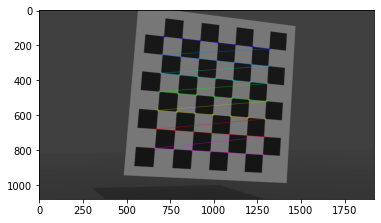

chessboards\c4Right.png


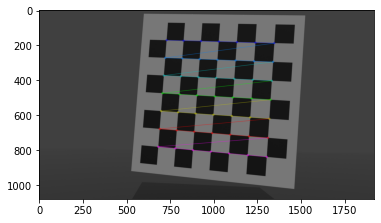

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
%matplotlib inline

chessboardSize = (7,7)
# termination criteria for the cornerSubPix algorithm
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
# objp stores coordinates 
objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

# Arrays to store object points and image points from each images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = sorted(glob.glob('chessboards/*.png'))

for fname in images:
    
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
   
    # Find the chess board corners (points where 2 black squares touch each other)
    ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)
    
    # If found, add object points and image points (after refining them)
    if ret:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv.drawChessboardCorners(img, chessboardSize, corners2, ret)
        print(fname)
        plt.imshow(img)
        plt.show()

    

In [2]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

#rotation matrix => convert vector to matrix
rmatLeft = cv.Rodrigues(rvecs[4])[0]
rmatRight = cv.Rodrigues(rvecs[5])[0]

print ('\n rvecs rodrigues : \n', rmatLeft)
print ('\n tvecs : \n', tvecs[4])

#full [R|t] matrix => add t in R
rotMatRight = np.concatenate((rmatRight,tvecs[5]), axis=1)
rotMatLeft = np.concatenate((rmatLeft,tvecs[4]), axis=1)

print ('\n matrice RT: \n', rotMatLeft)

#camera matrix (A [R|t])
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

print('\n matrice de projection : mtx @ matrice RT  \n',camLeft)

# find cx and cy for both cameras
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight,[[0,0,0,1]]), axis=0)) @ np.transpose([[0,0,0,1]])
#print('\n np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0) \n',np.concatenate((rotMatLeft,[[0,0,0,1]]), axis=0))
#print('\n np.transpose([[0,0,0,1]] : \n',np.transpose([[0,0,0,1]]))
print('\n centre optique gauche : \n',camWorldCenterLeft)

'''Compute vectorial product'''
def crossMat(v):
    v = v[:,0]
    return np.array([ [ 0,-v[2],v[1] ],[ v[2],0,-v[0] ],[ -v[1],v[0],0 ] ])


def matFondamental(camLeft,centerRight,camRight):
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight))

Fondamental = matFondamental(camRight,camWorldCenterLeft,camLeft)
print ('\nfondamental : \n', Fondamental)    


 rvecs rodrigues : 
 [[ 0.9805766  -0.0718773  -0.1824916 ]
 [ 0.08296156  0.99509733  0.05383945]
 [ 0.17772707 -0.06793349  0.98173221]]

 tvecs : 
 [[-2.29982476]
 [-3.66546698]
 [19.81589073]]

 matrice RT: 
 [[ 0.9805766  -0.0718773  -0.1824916  -2.29982476]
 [ 0.08296156  0.99509733  0.05383945 -3.66546698]
 [ 0.17772707 -0.06793349  0.98173221 19.81589073]]

 matrice de projection : mtx @ matrice RT  
 [[ 2.22944962e+03 -2.16122550e+02  5.59150657e+02  1.41915121e+04]
 [ 2.70023096e+02  2.05272327e+03  6.42408284e+02  2.98882882e+03]
 [ 1.77727065e-01 -6.79334893e-02  9.81732210e-01  1.98158907e+01]]

 centre optique gauche : 
 [[ -0.96257291]
 [  4.82835379]
 [-19.67625017]
 [  1.        ]]

fondamental : 
 [[-1.14738298e-03 -1.51160330e+00  9.81909580e+02]
 [-1.58288228e+00 -2.48925538e-04  1.76843099e+04]
 [ 1.01617006e+03 -1.47438915e+04 -1.90044521e+06]]


In [3]:
'''Get all red pixels from the image'''
def getRed(fname):
    img = cv.imread(fname)
    #acces only R channel from BGR 
    red = img[:,:,2]
    #keep only pixels between 127 and 255 in the red channel
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)
    return mask

'''Find epilines on right image of all given red points of left image'''
def getEpiLine(F,points):
    return F @ points
    
'''returns epilines (on right camera image) for all red points of the red line (of the left camera), from all images'''
def findEpilines(path):
    epilines = []
    
    for l in range(26):
        #correct format to match file name
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        #get the red mask    
        red = getRed(strp)
        tempEpilines = []
        pointsLeft = [[],[],[]]
        
        #i is the number of the line
        for i, line in enumerate(red):
            for pixel in line:
                if pixel != 0:
                    pixel = 1
            try:
                #weighted average => (0*0 + 1*0 + 2*0 + ... + 1248 * 1 + 1249 * 0) / n° of red pixels
                #for instance => (1261+1262+1267)/3 = 1263.33
                #give position of the red line in x axis
                pointsLeft[0].append(np.average(range(1920), weights = line))
                pointsLeft[1].append(i) # y axis
                pointsLeft[2].append(1)
            except:
                pass
        #from red line on left image, find corresponding epiline on right image
        epilinesRight = getEpiLine(Fondamental, pointsLeft)
        tempEpilines.append(pointsLeft)
        
        tempEpilines.append(epilinesRight)
        epilines.append(tempEpilines)
    return epilines

# epl = [ [ [Red_x_avg], [Y_avg], [1] ], [EpilineRight(i)] ] ]
epl = findEpilines('scanLeft/')
print ('epipiline : ',epl)

epipiline :  [[[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[], [], []], array([], shape=(3, 0), dtype=float64)], [[[1374.0, 1374.4176829268292, 1374.5752688172042, 1375.421836228288, 1375.524336283186, 1376.0158478605388, 1376.1365777080064, 1376.9183976261127, 1377.008486562942, 1377.3849821215733, 1377.5252873563218, 1377.633867276888, 1378.0040871934605, 1378.3838383838383, 1378.4704595185995, 1378.5434782608695, 1378.6061269146608, 1378.980824544583, 1379.0878701050622, 1379.440170940171, 1379.4968220338983, 1379.541798941799, 1379.58315565032, 1379.9592215013902, 1380.0414364640883, 1380.1147086031453, 1380.4664570230607, 1380.4984358706986, 1380.5349322210636, 1380.869365225391, 1380.939090909091, 1380.997277676951, 1381.0617059891108, 1381.1256830601094, 1381.1822344322345, 1381.4979296066253, 1381.52489626556, 1381.8558394160584, 1381.9147778785132, 1381.965734896303, 1382.0225428313797, 1382.070460704607, 138

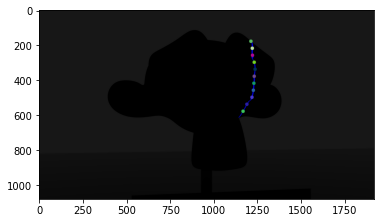

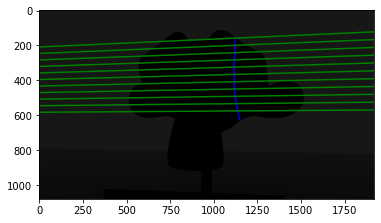

In [4]:
def drawAvgPoint(fname,EplLeft):
    img = cv.imread(fname)
    i = 0
    while i < len(EplLeft[0]):
        color = tuple(np.random.randint(0,255,3).tolist())
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),10,color,-1)
        i += 40
    plt.imshow(img)
    plt.show()

'''equation of a ligne => returns a value for y for a given x and coefficients'''
def lineY(coefs,x):
    a,b,c = coefs
    return-(c+a*x)/b


def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape
    for i in range(0,length,40):
        #print a, b and c of epiline
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'g')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0010.png',epl[10][0])
drawEpl('scanRight/scan0010.png',epl[10][1])

scanRight/scan0000.png


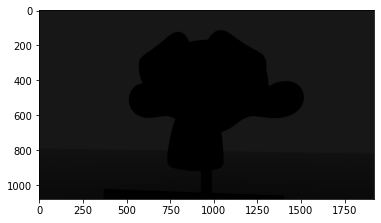

scanRight/scan0001.png


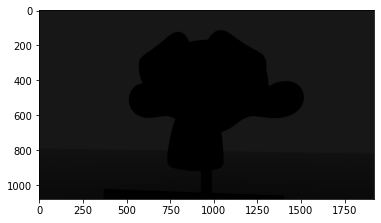

scanRight/scan0002.png


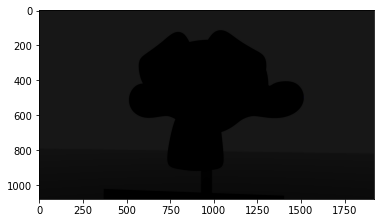

scanRight/scan0003.png


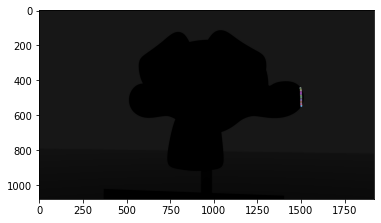

scanRight/scan0004.png


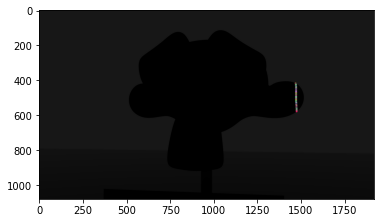

scanRight/scan0005.png


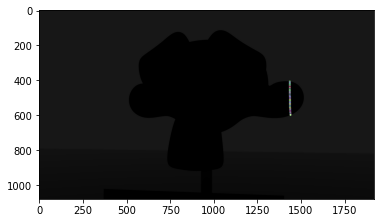

scanRight/scan0006.png


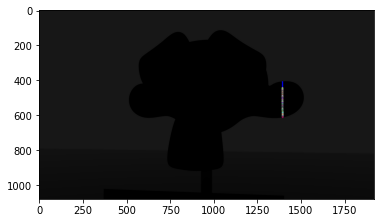

scanRight/scan0007.png


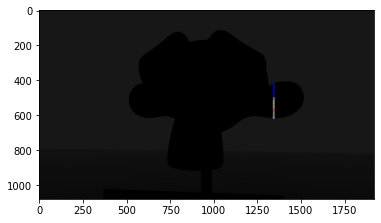

scanRight/scan0008.png


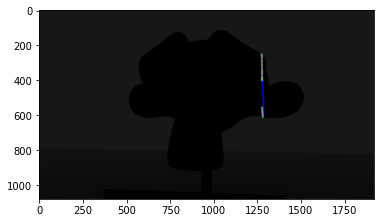

scanRight/scan0009.png


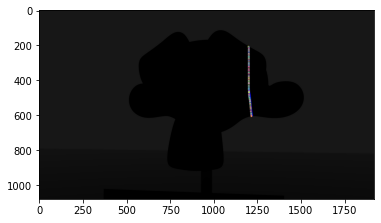

scanRight/scan0010.png


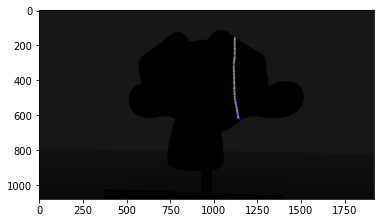

scanRight/scan0011.png


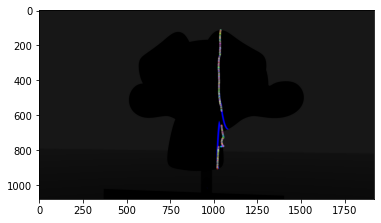

scanRight/scan0012.png


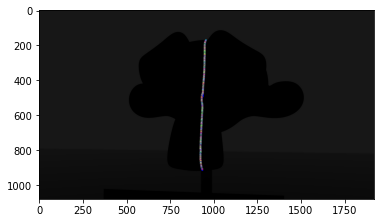

scanRight/scan0013.png


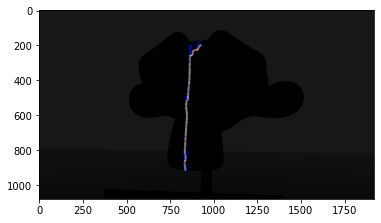

scanRight/scan0014.png


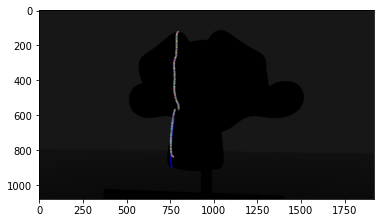

scanRight/scan0015.png


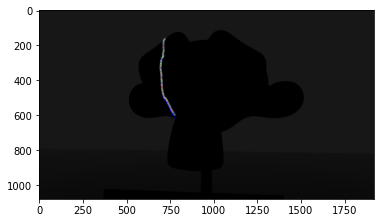

scanRight/scan0016.png


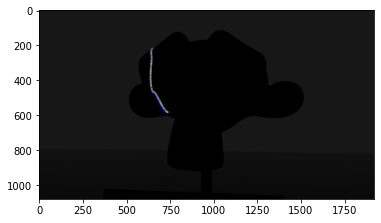

scanRight/scan0017.png


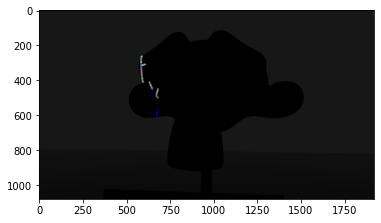

scanRight/scan0018.png


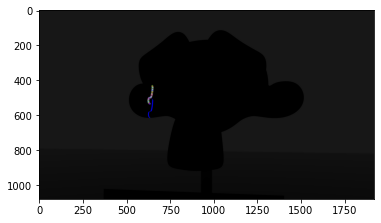

scanRight/scan0019.png


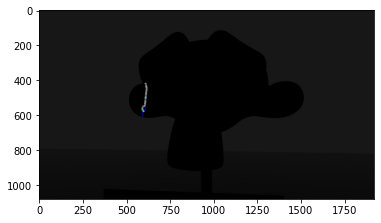

scanRight/scan0020.png


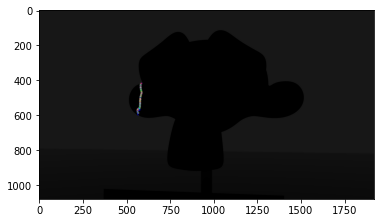

scanRight/scan0021.png


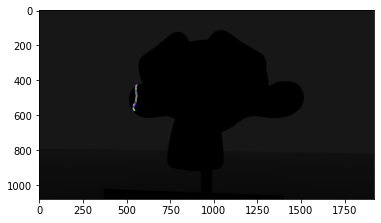

scanRight/scan0022.png


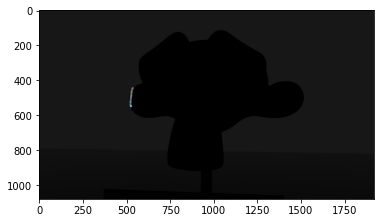

scanRight/scan0023.png


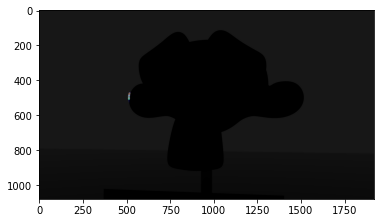

scanRight/scan0024.png


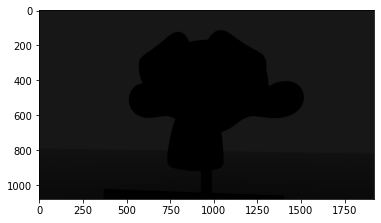

scanRight/scan0025.png


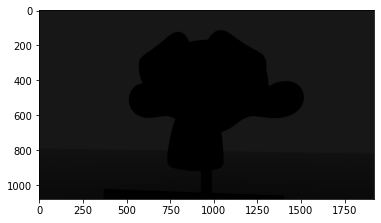

In [5]:
'''Get x position of the red point of each line of pixels (only one point per line, hence the average position)'''
def getRedAvg(fname):
    red = getRed(fname)
    redPoints = [[],[],[]]

    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            #same as in find epilines
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
    return redPoints

'''Find red points that are on an epiline, for each picture'''
def eplRedPoints(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getRedAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1] #keep only epiline and not red points (EplRight[l][0])
        print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i]) #average position
                y = int(lineY(eplImg[:,i],x)) #use of y = (-ax+c)/b to find y position
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                color = tuple(np.random.randint(0,255,3).tolist())
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        plt.imshow(scan)
        plt.show()
    return points


pointsRight = eplRedPoints('scanRight/scan',epl)

(Vector((0.33278095722198486, 0.07274532318115234, 0.16917037963867188)), Vector((0.33358773589134216, 0.0840267539024353, 0.17182111740112305)))
(Vector((0.3330647945404053, 0.07302713394165039, 0.16991424560546875)), Vector((0.3338734805583954, 0.08433461934328079, 0.1725708246231079)))
(Vector((0.3331642150878906, 0.0735468864440918, 0.1697254180908203)), Vector((0.33397290110588074, 0.08485441654920578, 0.17238174378871918)))
(Vector((0.3336184024810791, 0.0739293098449707, 0.169952392578125)), Vector((0.33442965149879456, 0.08527165651321411, 0.1726166158914566)))
(Vector((0.33369600772857666, 0.07443571090698242, 0.1698322296142578)), Vector((0.33450719714164734, 0.08577727526426315, 0.1724959909915924)))
(Vector((0.33392786979675293, 0.07503318786621094, 0.16923904418945312)), Vector((0.334739625453949, 0.0863824337720871, 0.17190434038639069)))
(Vector((0.33408868312835693, 0.07526540756225586, 0.1702594757080078)), Vector((0.33493518829345703, 0.08708982169628143, 0.1730360239

(Vector((0.2344881296157837, 0.04005289077758789, -0.11115074157714844)), Vector((0.23455481231212616, 0.04100547358393669, -0.11092168837785721)))
(Vector((0.2345188856124878, 0.0405268669128418, -0.11113166809082031)), Vector((0.23458543419837952, 0.04147744178771973, -0.11090312153100967)))
(Vector((0.23454737663269043, 0.04099893569946289, -0.11110305786132812)), Vector((0.23461377620697021, 0.04194735735654831, -0.11087505519390106)))
(Vector((0.23457884788513184, 0.041472434997558594, -0.11108589172363281)), Vector((0.23464512825012207, 0.042419180274009705, -0.11085831373929977)))
(Vector((0.23461174964904785, 0.04194784164428711, -0.11107444763183594)), Vector((0.23467792570590973, 0.04289310798048973, -0.11084724962711334)))
(Vector((0.23464524745941162, 0.04242134094238281, -0.11105537414550781)), Vector((0.23471125960350037, 0.04336414858698845, -0.11082878708839417)))
(Vector((0.23468017578125, 0.042897701263427734, -0.11104774475097656)), Vector((0.2347460687160492, 0.0438

(Vector((0.18144690990447998, 0.21893596649169922, -0.1864757537841797)), Vector((0.18157470226287842, 0.22075429558753967, -0.18605321645736694)))
(Vector((0.18147063255310059, 0.21940231323242188, -0.18643760681152344)), Vector((0.18159838020801544, 0.22121983766555786, -0.1860152930021286)))
(Vector((0.18150067329406738, 0.21987199783325195, -0.1864147186279297)), Vector((0.18162833154201508, 0.22168833017349243, -0.18599273264408112)))
(Vector((0.18153142929077148, 0.22034025192260742, -0.1863880157470703)), Vector((0.18165896832942963, 0.2221548855304718, -0.18596646189689636)))
(Vector((0.18156468868255615, 0.2208113670349121, -0.18637466430664062)), Vector((0.1816921830177307, 0.22262533009052277, -0.1859533190727234)))
(Vector((0.18159878253936768, 0.2212834358215332, -0.18636322021484375)), Vector((0.18172618746757507, 0.22309622168540955, -0.18594218790531158)))
(Vector((0.1816340684890747, 0.2217555046081543, -0.1863555908203125)), Vector((0.18176141381263733, 0.223567351698

(Vector((0.0916062593460083, 0.20736217498779297, -0.12157058715820312)), Vector((0.09135544300079346, 0.20375575125217438, -0.12240930646657944)))
(Vector((0.0916064977645874, 0.20781564712524414, -0.12145614624023438)), Vector((0.09135552495718002, 0.20420698821544647, -0.12229529768228531)))
(Vector((0.09150373935699463, 0.20821380615234375, -0.1210479736328125)), Vector((0.09125222265720367, 0.2045973241329193, -0.12188885360956192)))
(Vector((0.09152233600616455, 0.2086782455444336, -0.12099266052246094)), Vector((0.09127077460289001, 0.20506106317043304, -0.12183361500501633)))
(Vector((0.0914301872253418, 0.20908308029174805, -0.12061882019042969)), Vector((0.09117812663316727, 0.20545870065689087, -0.12146135419607162)))
(Vector((0.09144365787506104, 0.20954322814941406, -0.12054061889648438)), Vector((0.09119147807359695, 0.2059171348810196, -0.12138346582651138)))
(Vector((0.0914621353149414, 0.2100081443786621, -0.12048721313476562)), Vector((0.09120988100767136, 0.206380993

(Vector((-0.050456881523132324, 0.15481281280517578, 0.05724143981933594)), Vector((-0.051126837730407715, 0.14506013691425323, 0.054962653666734695)))
(Vector((-0.05042386054992676, 0.15529108047485352, 0.05725288391113281)), Vector((-0.05109380930662155, 0.1455385535955429, 0.05497436970472336)))
(Vector((-0.050447821617126465, 0.15606021881103516, 0.0560302734375)), Vector((-0.05111902579665184, 0.1462891399860382, 0.053747665137052536)))
(Vector((-0.050414979457855225, 0.15653562545776367, 0.05605125427246094)), Vector((-0.051086146384477615, 0.14676515758037567, 0.05376902595162392)))
(Vector((-0.05043768882751465, 0.15728998184204102, 0.054897308349609375)), Vector((-0.051140859723091125, 0.1470441371202469, 0.05250426009297371)))
(Vector((-0.05045962333679199, 0.15806150436401367, 0.05366325378417969)), Vector((-0.05116403102874756, 0.14779730141162872, 0.05126616731286049)))
(Vector((-0.050827980041503906, 0.1605997085571289, 0.0449676513671875)), Vector((-0.051541369408369064,

ValueError: x and y must be equal-length 1-D arrays

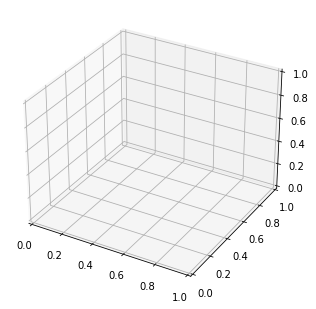

In [6]:
%matplotlib inline
from mathutils import geometry as pygeo
from mathutils import Vector
import json


def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))


def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    
    # get world/object 3D coordinates of all points 
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # characteristics points of retro projected lines
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)
    
    # display retro projected lines
    
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''  
    
    # intersection between two retroprojected lines = real world point
    # Essayer d'utiliser cv.triangulatePoints()
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)


def draw3DLine(start,end):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start,y_start,z_start = start
    x_end,y_end,z_end = end

    print("start = ({},{},{})".format(x_start,y_start,z_start))
    print("end = ({},{},{})\n".format(x_end,y_end,z_end))

    ax.scatter(x_start,y_start,z_start,c='r',marker='o')
    ax.plot([x_start ,x_end],[y_start,y_end],[z_start,z_end])


def getObjectPoint():
    point = [[],[],[]]
    points2 = [[],[],[]]
    for l in range(26):
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            linex = []
            liney = []
            linez = []
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                print(intersection)
                for inter in intersection:
                    inter *= 1000
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
                    linex.append(x)
                    liney.append(y)
                    linez.append(z)
                    points2[0].append(linex)
                    points2[1].append(liney)
                    points2[2].append(linez)
            except:
                pass
    return np.array(points2)
        

def drawPointObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    my_cmap = plt.get_cmap('hsv')
    ax.scatter3D(points[0,:],points[1,:],points[2,:],s=100,alpha = 0.8, c =(points[0,:]), cmap = my_cmap, marker='.', )     
        
    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    

def drawSurfaceObject(points):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(points[0,:],points[1,:],points[2,:])     

    ax.view_init(-289,-80)
    plt.axis('off')
    plt.show()
    
    
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point2.txt','+w') as file:
        json.dump(data,file)


point = getObjectPoint()
drawSurfaceObject(point)
drawPointObject(point)
pointToJson(point)